# Is ERA5 land a good data set to calculate PV generation?
well, we will see

## 1) import the libraries and define the function for the PV calculation 

In [53]:
import xarray as xr
import pvlib
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import geopandas
#define the data sets that are going to be used
input_era5l_data = "/home/lramirez/my-data/ERA5_land_data/derived/era5l_2001_01.nc"
installations_chile = "/home/lramirez/my-data/pv_generation_per_country/chile/solares_fd0779de_0870_4194_b962_83a842d8c316.shp"
generation_chile = "/home/lramirez/my-data/pv_generation_per_country/chile/OP140101.xls"

In [ ]:

#load the data set
era5 = xr.open_mfdataset(input_era5l_data, combine='nested', concat_dim='time')
                         
                         
                         #, combine='by_coords',\
                         #decode_cf=False, chunks={'lon': 1000, 'lat':1000},\
                        #parallel=True)


def pv_output_1kWp(start_time,end_time,lons,lats,system_size):
    location = Location(latitude=lats, longitude=lons)
    slope = lats
    if lons > 0:
        aspect = 180
    elif lons < 0:
        aspect = 0
    GHI_in_j = era5.var169.sel(time=slice(start_time,end_time),lon=lons,lat=lats).diff("time", 1, label="upper")
    ghi_era5l = (GHI_in_j.where(GHI_in_j > 0, 0))/3600
    timepre = ghi_era5l["time"].values
    timeindex = pd.to_datetime(timepre, dayfirst=True, utc=True, infer_datetime_format=True)
    dayofyear = ghi_era5l.time.dt.dayofyear.values
    Zenith = pvlib.solarposition.get_solarposition(timepre, latitude=lats, longitude=lons).zenith.values
    erbs = pvlib.irradiance.erbs(ghi_era5l, zenith=Zenith, datetime_or_doy=dayofyear)
    dni_era5l = erbs["dni"]
    dhi_era5l = erbs["dhi"]
    temperature_pre = (era5.var167.sel(time=slice(start_time,end_time),lon=lons,lat=lats))-273.15
    temperature = temperature_pre[1:].values
    wind_speed_pre2 = (np.sqrt(((era5.var165.sel(time=slice(start_time,end_time),lon=lons,lat=lats))**2)+
             ((era5.var166.sel(time=slice(start_time,end_time),lon=lons,lat=lats))**2)))
    wind_speed_pre1 = wind_speed_pre2 * ((np.log(1/0.25))/(np.log(10/0.25)))
    wind_speed = wind_speed_pre1[1:].values
    weather = pd.DataFrame({'ghi': ghi_era5l.values, 
                        'dni': dni_era5l, 
                        'dhi': dhi_era5l, 
                        'temp_air': temperature, 
                        'wind_speed': wind_speed},
                       index=timeindex)
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    #the follow selection requires some sort of automatization
    sandia_module = sandia_modules['Silevo_Triex_U300_Black__2014_']
    STC = 300
    cec_inverter = cec_inverters['ABB__MICRO_0_3_I_OUTD_US_240_240V__CEC_2014_']
    #check that the Paco is at least equal to the STC
    number_of_panels_1kWp = 1000/STC
    area_1kWp = number_of_panels_1kWp * sandia_module['Area']
    system = PVSystem(surface_tilt=slope, surface_azimuth=aspect,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
    mc = ModelChain(system, location)
    mc.run_model(times=weather.index, weather=weather)
    pv_output = mc.ac * number_of_panels_1kWp * system_size
    return pv_output

In [ ]:
print(era5)

## 2) create data frames for the installations and the measured generation

In [65]:


pvs_chile = geopandas.read_file(installations_chile)

pvs_chile['geometry']
pvs_chile.crs
pvs_chile_4326 = pvs_chile.to_crs(epsg=4326)
pvs_chile_4326
#before runing the next step the installations of all countris have to be merged in the same list!
#for the first try only with the data from chile the names call is made directly from the shp
#it could also be that is better to work with every country separately?? or make new IDS for the installations?
installations_list = pvs_chile_4326["NOMBRE"]

#create a dataframe with the key data that is necesary for the comparison
installations = pd.DataFrame({'lats': pvs_chile_4326.geometry.y.values , 
                        'lons': pvs_chile_4326.geometry.x.values , 
                        'size': pvs_chile_4326['POTENCIA'].values, 
                        'start_time': pd.to_datetime(pvs_chile_4326['F_OPERACIO'].values), 
                        'end_time': pd.to_datetime('2018-12-30')},
                       index=installations_list)

#create a data frame for the time series of energy generation of each plant
date_range = pd.date_range(start='1/1/2014', end='31/12/2018', freq='H')
output_installations = pd.DataFrame(columns=installations_list, index=pd.to_datetime(date_range))

#read the xls original files and fill the output_installations data frame
ouput_chile = pd.read_excel(generation_chile, sheet_name='gen_real', header=2, index_col=1)




'''

pvs_chile_4326[["NOMBRE"]==ALTURAS DE OVALLE].geometry.x
#pvs_chile.plot()
#pvs_chile_4326.plot(figsize=(6, 20))
#pvs_chile
'''

#installations
#output_installations
ouput_chile

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Total
Centrales,,,,,,,,,,,,,,,,,,,,,
Pasada,NaN,1501.23,1441.5,1450.04,1428.86,1401.24,1400.63,1428.55,1432.75,1431.26,...,1570.46,1565.03,1560.37,1531.61,1509.05,1518.63,1629.63,1673.52,1624.55,36359.81
Los Molles,NaN,0.00,0,0,0,0.00,0,0.00,0.00,0.00,...,3.00,3.00,3.00,2.00,2.00,2.00,5.00,9.00,9.00,48.00
Sauce Andes,NaN,0.97,0.97,0,0,0.00,0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.94
Aconcagua Ublanco,NaN,56.90,56.9,56.9,56.9,56.90,56.9,56.90,56.90,56.90,...,55.00,57.00,56.90,56.90,56.90,56.90,56.90,56.90,56.90,1349.80
Aconcagua Ujuncal,NaN,28.60,28.7,28.7,28.7,28.70,28.7,28.70,28.70,28.80,...,28.40,28.50,28.80,28.80,28.70,28.70,28.60,28.90,28.90,688.40
Los Quilos,NaN,37.60,37.6,37.7,37.7,37.70,37.6,37.60,36.40,37.40,...,37.70,37.70,37.70,37.70,37.70,37.70,37.70,37.70,37.70,898.30
Florida,NaN,22.00,22,23,22,23.00,23,22.00,23.00,23.00,...,23.00,22.00,23.00,22.00,23.00,21.00,23.00,22.00,22.00,541.00
Maitenes,NaN,13.00,13,13,13,13.00,13,13.00,13.00,13.00,...,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,13.00,326.20
Alfalfal,NaN,175.10,174.9,174.9,168.8,158.70,162.8,175.20,174.90,174.30,...,174.10,174.60,174.60,174.70,174.60,169.20,175.00,174.60,175.00,4153.60


## from here the cells are dedicated to testing

In [2]:
pv_installation = pv_output_1kWp("2001-01-01T01:00:00","2001-01-30T01:00:00",9.0,54.0,1)

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


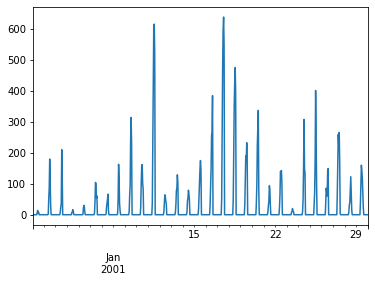

In [3]:
pv_installation.plot() 